In [265]:
from typing import Optional, List
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os
import codecs
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [231]:
class ZamokClassifier:
    def __init__(self, load_path: Optional[str] = None, mx=150) -> None:
        if load_path:
            with open(load_path+'.vectorizer.pk', 'rb') as fin:
                self.vectorizer = pickle.load(fin)
            with open(load_path+'.model.pk', 'rb') as fin:
                self.log_model = pickle.load(fin)
        else:
            self.vectorizer = TfidfVectorizer(max_features=mx)
            self.log_model = LogisticRegression()
            
    def preproc(self, texts):
        bad = '1234567890()!@#$%^&*,./abcdefghijklmnopqrstuvwxyz-—_+=«»\n:;[]–’…'+"'"+'"'
        clear_ = []
        for text in texts:
            text = text.lower()
            for letter in text:
                if letter in bad:
                    text = text.replace(letter, '')
                text = text.replace('  ', ' ')
            clear_.append(text)
        return clear_
            
    def train(self, texts1: List[str], texts2: List[str]) -> None:
        # castles_tokens = [token for text in texts1 for token in text.split()]
        # locks_tokens = [token for text in texts2 for token in text.split()]
        texts1, texts2 = self.preproc(texts1), self.preproc(texts2)
        self.vectorizer.fit(texts1+texts2)
        x_castles = self.vectorizer.transform(texts1).toarray()
        x_locks = self.vectorizer.transform(texts2).toarray()
        X = np.concatenate([x_castles, x_locks], axis=0)
        y = np.concatenate([[1]*len(x_castles), [0]*len(x_locks)])
        self.log_model.fit(X, y)
    
    def save(self, path: str) -> None:
        with open(path+'.vectorizer.pk', 'wb') as fin:
            pickle.dump(self.vectorizer, fin)
        with open(path+'.model.pk', 'wb') as fin:
            pickle.dump(self.log_model, fin)
        
    
    def predict(self, text: str) -> str:
        emb = self.vectorizer.transform(self.preproc([text]))
        class_ = self.log_model.predict(emb)
        if class_:
            ans = 'YES'
        else:
            ans = 'NO'
        return ans
        

In [202]:
castles = []
for filename in os.listdir("castles/"):
    if filename[::-1][:4] == 'txt.':
        fileObj = codecs.open("castles/"+filename, 'r', "utf_8_sig")
        txt = fileObj.readlines()
        castles.extend(txt)
        fileObj.close()
        
locks = []
for filename in os.listdir("locks/"):
    if filename[::-1][:4] == 'txt.':
        fileObj = codecs.open("locks/"+filename, 'r', "utf_8_sig")
        txt = fileObj.readlines()
        locks.extend(txt)
        fileObj.close()

In [203]:
castles[6]

'До 1975 года Шлоссбург был независимым городком, после чего вошёл в состав Золингена. В настоящее время замок является популярным туристическим местом. В замке действует музей графства Берг и находятся несколько исторических памятников разных эпох. С 2005 года на территории замка проводятся археологические раскопки.\n'

In [204]:
clear_castles[6]

'до года шлоссбург был независимым городком после чего вошёл в состав золингена в настоящее время замок является популярным туристическим местом в замке действует музей графства берг и находятся несколько исторических памятников разных эпох с года на территории замка проводятся археологические раскопки'

In [205]:
len(castles)

329

In [206]:
len(locks)

284

In [216]:
for x in model.log_model.coef_:
    for y in x:
        if abs(y) < 0.075:
            print(y)

0.04136746740009033
0.07433988442316418
-0.035083719430385706
-0.059138165870454985
0.048981730817399795
0.06359385314026234
0.0511310626322918
-0.036297504607499066
0.06675831646438252


  0%|          | 0/98 [00:00<?, ?it/s]

1570 0.9820554649265906


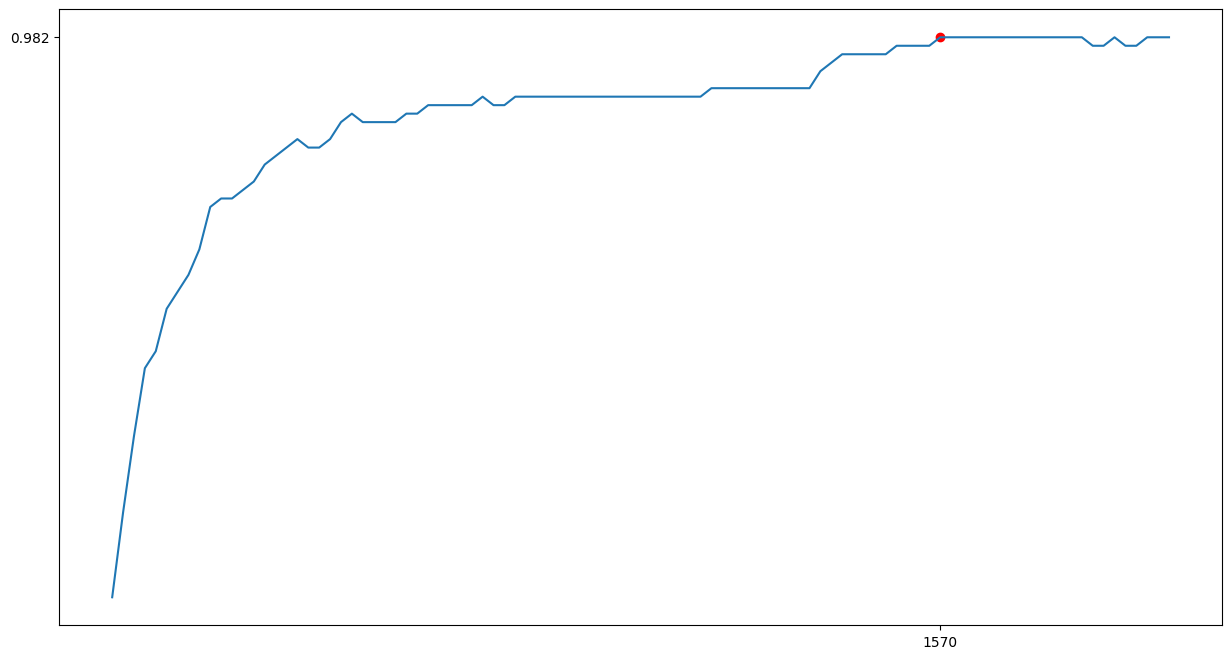

In [282]:
xx, yy = [], []
for m in tqdm(range(50, 2000, 20)):
    i = 0
    model = ZamokClassifier(mx=m)
    model.train(castles, locks)
    for x in locks:
        if model.predict(x) == "NO":
            i+=1
    for x in castles:
        if model.predict(x) == "YES":
            i+=1
    # print(i/(len(castles)+len(locks)), m)
    yy.append(i/(len(castles)+len(locks)))
    xx.append(m)
plt.figure(figsize=(15, 8))
plt.plot(xx, yy)
plt.scatter([xx[yy.index(max(yy))]], [max(yy)], c='r')
# plt.plot([0,m], [max(yy), max(yy)])
plt.yticks([max(yy)])
plt.xticks([xx[yy.index(max(yy))]])
plt.savefig("plot.pdf")
print(xx[yy.index(max(yy))], max(yy))

In [84]:
np.concatenate([x1,x2], axis=0).shape

(613, 100)

In [85]:
np.concatenate([[0]*len(x1), [1]*len(x2)]).shape

(613,)

In [86]:
model.save('test_model')

In [87]:
model1 = ZamokClassifier('test_model')

In [88]:
model1.predict(locks[101])

'NO'